Using a neural network to predict stock prices, using only basic data

In [194]:
%matplotlib inline

from matplotlib import pyplot as plt
import datetime
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

# increase default figure size for matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [230]:
# I will implement a forward distribution, to predict values for the future

def create_columns(df, days=7):
    columns = df.columns
    for n in range(1,days):
        for column in columns:
            new_column = "d{}-{}".format(n, column)
            df[new_column] = 0
    return df

def construct_features(df, days=7):
    # build the new features 
    for n in range(1,days):
        for column in columns: 
            for row in range(df.shape[0]):
                column_to_update = "d{}-{}".format(n, column)
                if row+1 > n:
                    df.ix[row, column_to_update] = df.ix[row-n, column]
                else:
                    df.ix[row, column_to_update] = np.nan

    # drop existing features
    # df = df.drop(columns - ['Adj Close'], axis=1)
    
    #drop NAs
    df = df.dropna()
    
    return df

# train test split, non-randomized
def split(array, test_size):
    return array[:test_size], array[test_size:]

# scale
def scale(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

# classify
def train(X_train, y_train, reg=0.1):
    clf = Lasso(alpha=reg)
    clf.fit(X_train, y_train)
    return clf 

# score
def predict(clf, y_test):
    return clf.predict(y_test)


In [247]:
# import data from yahoo finance
start_date = datetime.datetime(2012,1,1)
end_date = datetime.datetime(2016,7,31) 
symbol = "HGTX3.SA"
df_base = web.DataReader(symbol, 'yahoo', start_date, end_date)

#start from scratch
df_base.columns

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close'], dtype='object')

In [280]:
# transform dataframe
df = df_base.drop(['Open', 'High', 'Low', 'Close'], axis=1)
days=30
df = create_columns(df, days=days)
df = construct_features(df, days=days)
df.head()

,Volume,Adj Close,d1-Volume,d1-Adj Close,d2-Volume,d2-Adj Close,d3-Volume,d3-Adj Close,d4-Volume,d4-Adj Close,...,d25-Volume,d25-Adj Close,d26-Volume,d26-Adj Close,d27-Volume,d27-Adj Close,d28-Volume,d28-Adj Close,d29-Volume,d29-Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-13,1139900,34.28,1114700.0,33.59,986300.0,33.68,973000.0,33.91,1296700.0,33.85,...,1034000.0,28.84,1248800.0,28.36,902900.0,27.75,1322800.0,28.03,1104600.0,27.82
2012-02-14,1012000,34.28,1139900.0,34.28,1114700.0,33.59,986300.0,33.68,973000.0,33.91,...,991900.0,29.67,1034000.0,28.84,1248800.0,28.36,902900.0,27.75,1322800.0,28.03
2012-02-15,1914700,35.13,1012000.0,34.28,1139900.0,34.28,1114700.0,33.59,986300.0,33.68,...,2130600.0,30.55,991900.0,29.67,1034000.0,28.84,1248800.0,28.36,902900.0,27.75
2012-02-16,1781900,35.89,1914700.0,35.13,1012000.0,34.28,1139900.0,34.28,1114700.0,33.59,...,1214300.0,30.73,2130600.0,30.55,991900.0,29.67,1034000.0,28.84,1248800.0,28.36
2012-02-17,950900,36.05,1781900.0,35.89,1914700.0,35.13,1012000.0,34.28,1139900.0,34.28,...,1428100.0,30.73,1214300.0,30.73,2130600.0,30.55,991900.0,29.67,1034000.0,28.84


In [287]:
# get X and y
df_short = df.iloc[:800]
X = df_short.drop(['Adj Close', 'Volume'], axis=1).values
y_price, y_volume = df_short['Adj Close'].values, df_short['Volume'].values

# separate test and train 
test_size = int(X.shape[0]*.9)
X_train, X_test = split(X, test_size)
y_price_train, y_price_test = split(y_price, test_size)
y_volume_train, y_volume_test = split(y_volume, test_size)

# train two classifiers, one for price, one for volume
clf_price = train(X_train, y_price_train, reg=0.2)
clf_volume = train(X_train, y_volume_train, reg=0.2)

X_pred = X_train
y_price_pred = np.array([])
y_volume_pred = np.array([])

for _ in y_price_test:
    # get the features
    x = X_pred[-1]

    # predict 
    price = clf_price.predict(x.reshape(1, -1))
    volume = clf_volume.predict(x.reshape(1, -1))
    
    # append to y values
    y_price_pred = np.append(y_price_pred, price)
    y_volume_pred = np.append(y_volume_pred, price)
    
    # Create a new row, add the predition values, and append to X
    x = X_pred[-1][:-2]
    x = np.append(price, x)
    x = np.append(volume, x)
    X_pred = np.append(X_pred, x.reshape(1, -1), axis=0)
    

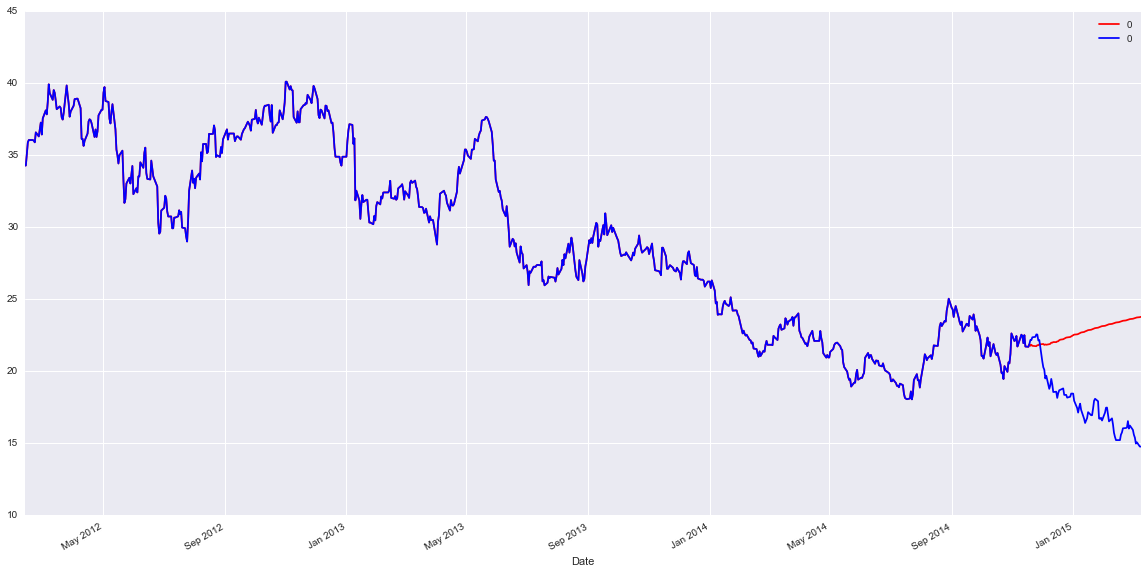

In [288]:
# plot
full_pred = pd.DataFrame(np.append(y_price_train, y_price_pred), index=df_short.index)
base = pd.DataFrame(np.append(y_price_train, y_price_test), index=df_short.index)
ax = full_pred.plot(color='red')
base.plot(color='blue', ax=ax)

In [289]:
r2_score(y_price_test, y_price_pred), r2_score(y_volume_test, y_volume_pred)

(-6.6889887663405956, -0.11780684788940587)

In [262]:
zip(df.columns.difference(['Adj Close', 'Volume']), clf_price.coef_)

[('d1-Adj Close', 2.2275972636621901e-08),
 ('d1-Volume', 0.97301038281561547),
 ('d10-Adj Close', -3.6116060946263654e-08),
 ('d10-Volume', 0.00042112780306676698),
 ('d11-Adj Close', 6.2702325597901116e-09),
 ('d11-Volume', 0.0),
 ('d12-Adj Close', 1.0437383259922238e-08),
 ('d12-Volume', 0.0),
 ('d13-Adj Close', 7.2410240274651275e-08),
 ('d13-Volume', 0.0),
 ('d14-Adj Close', -4.1941511060095663e-08),
 ('d14-Volume', 0.0),
 ('d15-Adj Close', -2.8972816423380235e-08),
 ('d15-Volume', 0.0),
 ('d16-Adj Close', 3.8973236404653462e-09),
 ('d16-Volume', 0.0),
 ('d17-Adj Close', 2.1817182895070569e-08),
 ('d17-Volume', 0.0),
 ('d18-Adj Close', 2.2314478704482872e-09),
 ('d18-Volume', 0.0),
 ('d19-Adj Close', 8.5017560725262531e-10),
 ('d19-Volume', 0.0),
 ('d2-Adj Close', 3.840793935591789e-08),
 ('d2-Volume', 0.0),
 ('d20-Adj Close', 2.8553948579854349e-08),
 ('d20-Volume', 0.0),
 ('d21-Adj Close', -5.3854493949088589e-09),
 ('d21-Volume', 0.0),
 ('d22-Adj Close', -1.8638099092788776e-08

In [263]:
zip(y_price_test, y_price_pred)

[(22.16, 22.198052320446372),
 (22.350000000000001, 22.119554591697216),
 (22.379999999999999, 22.025351654775161),
 (22.550000000000001, 21.969541663325657),
 (22.539999999999999, 22.239022517628744),
 (22.129999999999999, 22.213358354164047),
 (22.16, 22.161463787237757),
 (20.68, 22.478141395995316),
 (20.27, 22.564420994313583),
 (20.100000000000001, 22.556460879800895),
 (19.489999999999998, 22.631920830090699),
 (19.68, 22.777843780348235),
 (18.77, 22.849808156998023),
 (19.0, 22.80284204682043),
 (19.460000000000001, 22.612663484237462),
 (19.09, 22.488150789394744),
 (18.550000000000001, 22.498466403803018),
 (18.57, 22.595778044939653),
 (18.140000000000001, 22.497581846101603),
 (18.469999999999999, 22.441360764221081),
 (18.670000000000002, 22.490164447785702),
 (18.699999999999999, 22.504879618762544),
 (18.800000000000001, 22.447257512500549),
 (18.350000000000001, 22.260282098931114),
 (18.350000000000001, 22.439898967163469),
 (18.350000000000001, 22.349001966234962),
 

# Old tests

In [218]:
print X.shape, X_pred.shape
print y_price_train.shape, y_price_test.shape, y_price_pred.shape
print y_volume_train.shape, y_volume_test.shape, y_volume_pred.shape


(1133, 12) (1133, 12)
(1019,) (114,) (114,)
(1019,) (114,) (114,)


In [78]:
# start the machine learning
y = df['Adj Close']
X = df.drop('Adj Close', axis=1)

In [53]:
#create new columns
df = df_base.copy()
df = df.drop(['Open', 'High', 'Low', 'Close'], axis=1)
columns = df.columns
for n in range(1,7):
    for column in columns:
        new_column = "d{}-{}".format(n, column)
        df[new_column] = 0

df.shape, columns

Index([u'Volume', u'Adj Close', u'd1-Volume', u'd1-Adj Close', u'd2-Volume',
       u'd2-Adj Close', u'd3-Volume', u'd3-Adj Close', u'd4-Volume',
       u'd4-Adj Close', u'd5-Volume', u'd5-Adj Close', u'd6-Volume',
       u'd6-Adj Close'],
      dtype='object')

In [56]:
# drop NAs
df = df.dropna()
df.tail()

,Adj Close,d1-Volume,d1-Adj Close,d2-Volume,d2-Adj Close,d3-Volume,d3-Adj Close,d4-Volume,d4-Adj Close,d5-Volume,d5-Adj Close,d6-Volume,d6-Adj Close
Date,,,,,,,,,,,,,
2016-07-25,12.03,33938400.0,11.94,37748600.0,11.85,49261200.0,11.82,53692000.0,11.78,77358900.0,11.55,51223500.0,11.02
2016-07-26,11.88,47192000.0,12.03,33938400.0,11.94,37748600.0,11.85,49261200.0,11.82,53692000.0,11.78,77358900.0,11.55
2016-07-27,11.51,38304800.0,11.88,47192000.0,12.03,33938400.0,11.94,37748600.0,11.85,49261200.0,11.82,53692000.0,11.78
2016-07-28,11.44,51952100.0,11.51,38304800.0,11.88,47192000.0,12.03,33938400.0,11.94,37748600.0,11.85,49261200.0,11.82
2016-07-29,11.87,40663100.0,11.44,51952100.0,11.51,38304800.0,11.88,47192000.0,12.03,33938400.0,11.94,37748600.0,11.85


In [55]:
# update values
for n in range(1,7):
    for column in columns: 
        for row in range(df.shape[0]):
            column_to_update = "d{}-{}".format(n, column)
            if row+1 > n:
                df.ix[row, column_to_update] = df.ix[row-n, column]
            else:
                df.ix[row, column_to_update] = np.nan
                
# drop existing values
df = df.drop(columns - ['Adj Close'], axis=1)

/Users/lucasosouza/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


,Adj Close,d1-Volume,d1-Adj Close,d2-Volume,d2-Adj Close,d3-Volume,d3-Adj Close,d4-Volume,d4-Adj Close,d5-Volume,d5-Adj Close,d6-Volume,d6-Adj Close
Date,,,,,,,,,,,,,
2012-01-02,19.96403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,20.58876,20391300.0,19.96403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,20.73576,22940500.0,20.58876,20391300.0,19.96403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,20.49689,18736900.0,20.73576,22940500.0,20.58876,20391300.0,19.96403,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,20.51527,19489000.0,20.49689,18736900.0,20.73576,22940500.0,20.58876,20391300.0,19.96403,NaN,NaN,NaN,NaN
2012-01-09,20.79088,13941000.0,20.51527,19489000.0,20.49689,18736900.0,20.73576,22940500.0,20.58876,20391300.0,19.96403,NaN,NaN
2012-01-10,21.03894,14665100.0,20.79088,13941000.0,20.51527,19489000.0,20.49689,18736900.0,20.73576,22940500.0,20.58876,20391300.0,19.96403
2012-01-11,21.04813,21084100.0,21.03894,14665100.0,20.79088,13941000.0,20.51527,19489000.0,20.49689,18736900.0,20.73576,22940500.0,20.58876
2012-01-12,21.20431,19836100.0,21.04813,21084100.0,21.03894,14665100.0,20.79088,13941000.0,20.51527,19489000.0,20.49689,18736900.0,20.73576


In [63]:
# split train and test
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# fit into a linear regression with L1 regularization, aka Lasso
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.0001)
clf.fit(X_train, y_train)

#score
score_train =  clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)
regular_diff = (score_train - score_test)
print score_train, score_test

# predict
y_pred = clf.predict(X_test)
print regular_diff.mean(), (y_pred - y_test).mean()

# very low alpha -> models equals regression solved with ordinary
# least square, also solved by LinearRegression object

0.982789701769 0.982433969634
0.000355732134539 0.0686395574231


In [ ]:
# zip(df.columns - ['Adj Close'], clf.coef_)

In [ ]:
# index the results
y_test_df = pd.DataFrame(y_test, index=df.iloc[800:].index)
y_pred_df = pd.DataFrame(clf.predict(X_test), index=df.iloc[800:].index)

# plot
ax = y_test_df['2016'].plot(color='blue')
y_pred_df['2016'].plot(color='red', ax=ax)

I have something, a logistic regression with 0.98 R2 score. All the results seem delayed by one day, which sucks. What if I randomize?

In [62]:
# train test split, randomized
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# classify
clf_rdn = Lasso(alpha=0.0001)
clf_rdn.fit(X_train, y_train)

# score
score_train =  clf_rdn.score(X_train, y_train)
score_test = clf_rdn.score(X_test, y_test)
random_diff = score_train - score_test
print score_train, score_test

# predict
y_pred_rdn = clf.predict(X_test)
print random_diff.mean(), (y_pred_rdn - y_test).mean()

0.99294251796 0.9905550273
0.00238749066056 2.33240370033


Randomized seems to yield better results. The R2 score is from 0.985 to 0.992, while not randomized the R2 is 0.981. Randomizing might have solved issues with overplotting.

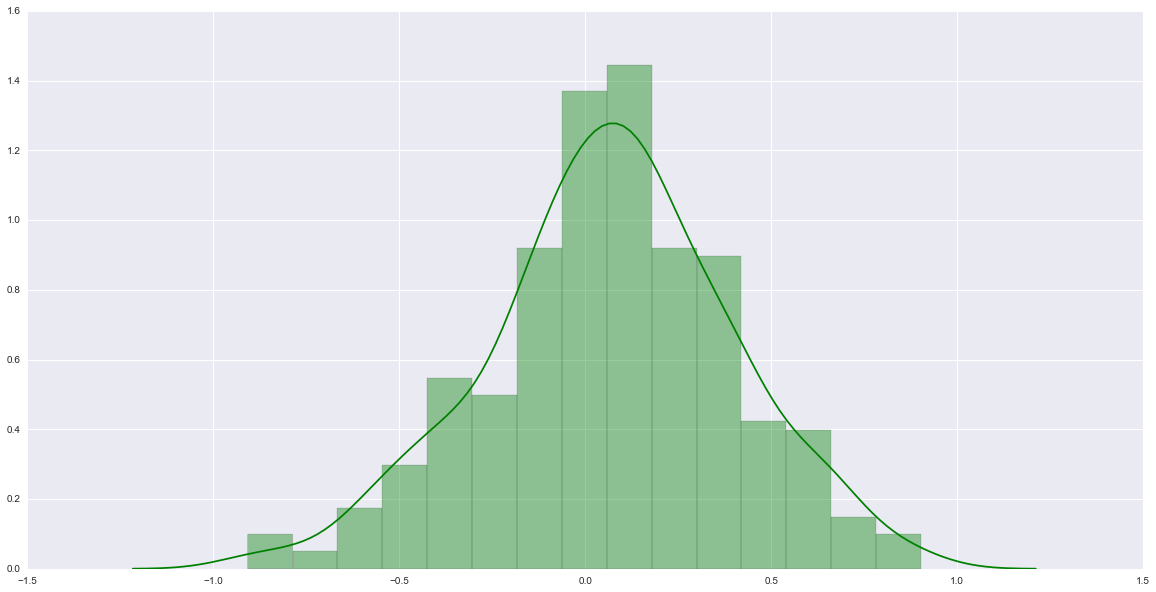

In [27]:
# compare both results
ax1 = sns.distplot(errors, color='green', norm_hist=False)

#sns.kdeplot(errors_rnd, color='purple')


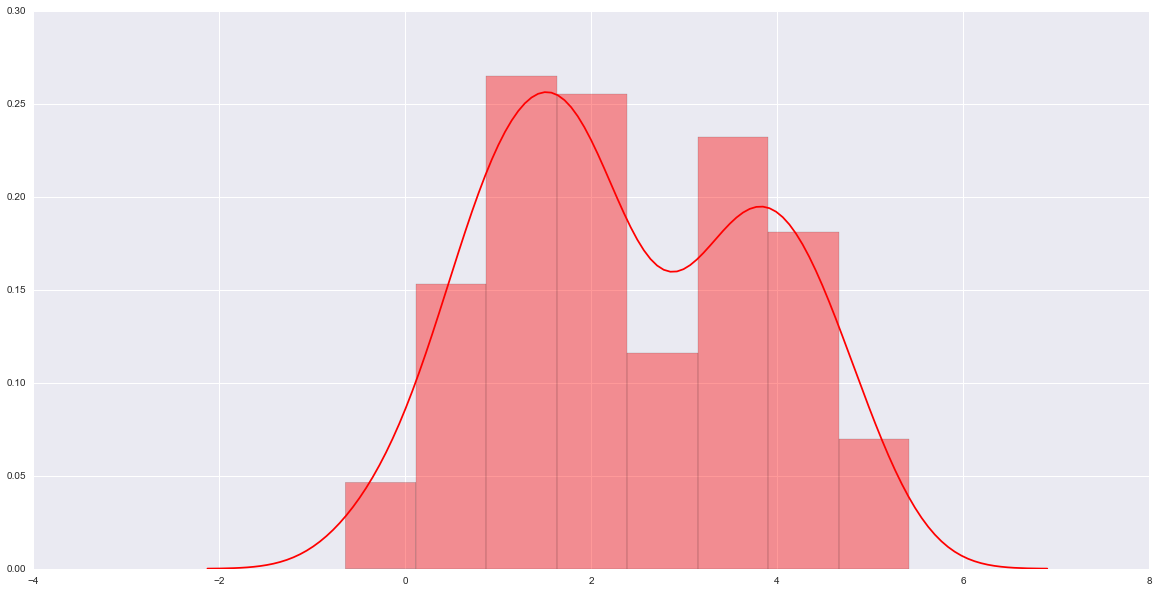

In [21]:
ax2 = sns.distplot(errors_rdn, color='red', norm_hist=False)


How is the R2 score higher, in the randomized model, but the distribution shows more values concentrated around 0?

Errors are higher when I randomize, taking the values out of their natural order